#### How to use Boosting

`https://keeryang.github.io/papers/Profits_2021Aug28.pdf`

In [430]:
import optuna
from lightgbm import plot_importance, LGBMRegressor
import getFamaFrenchFactors as gff
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [431]:
stocks_df = pd.read_csv('../data/market_data/sp500/sp500_stocks.csv')
df = stocks_df.pivot(
    index='Date', columns='Symbol', values='Adj Close')

df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

df.head()

Symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,20.122227,4.496877,6.470741,NaN,NaN,18.952162,7.994444,32.212460,37.090000,23.694084,...,52.883579,9.905468,41.963718,12.918809,43.185623,NaN,19.158102,52.587051,28.670000,NaN
2010-01-05,19.903643,5.005957,6.481929,NaN,NaN,18.799042,7.967778,32.411549,37.700001,23.656675,...,52.765053,10.115747,44.515926,12.765595,43.354244,NaN,19.092571,54.251759,28.620001,NaN
2010-01-06,19.832930,4.798554,6.378825,NaN,NaN,18.903446,7.933333,32.756096,37.619999,23.611784,...,53.614498,10.003899,43.932011,12.790110,43.728970,NaN,18.956089,54.234219,28.400000,NaN
2010-01-07,19.807215,4.939964,6.367033,NaN,NaN,19.060045,7.886667,32.725471,36.889999,23.424749,...,53.456463,9.959157,44.870213,12.734954,43.591564,NaN,18.950626,55.478374,27.690001,NaN
2010-01-08,19.800785,4.845691,6.409364,NaN,NaN,19.157482,7.871111,32.595306,36.689999,23.559416,...,53.397202,9.867439,44.548744,12.741086,43.416687,NaN,18.956089,54.313072,27.600000,NaN


In [432]:
tickers = ['AAPL']

In [433]:
ff5 = pd.DataFrame(gff.famaFrench5Factor(frequency='m'))
ff5.head()

,date_ff_factors,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-31,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027
1,1963-08-31,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025
2,1963-09-30,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027
3,1963-10-31,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029
4,1963-11-30,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027


In [434]:
fff = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

N_lags = 10

for f in fff:
  for i in range(1, N_lags):
    ff5[f'{f}_{i}L'] = ff5[f].shift(-i)
    

In [435]:
mon = pd.DataFrame(df[tickers[0]]).resample('ME').last()
mon_rets = mon.pct_change().dropna()

In [436]:
import numpy as np

# Пример преобразования с использованием логарифма
log_transformed_features = np.log1p(
    ff5[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']])

log_transformed_features

,Mkt-RF,SMB,HML,RMW,CMA,RF
0,-0.003908,-0.004108,-0.009747,0.006777,-0.011870,0.002696
1,0.049457,-0.008032,0.017840,0.003594,-0.003506,0.002497
2,-0.015825,-0.005214,0.001299,-0.007125,0.002896,0.002696
3,0.024985,-0.013998,-0.001001,0.027615,-0.020305,0.002896
4,-0.008536,-0.008839,0.017349,-0.005113,0.022153,0.002696
...,...,...,...,...,...,...
724,0.084709,-0.001201,0.016267,-0.039885,-0.010050,0.004390
725,0.047551,0.070645,0.048123,-0.031181,0.013114,0.004291
726,0.007075,-0.059113,-0.024088,0.006876,-0.009646,0.004689
727,0.049361,-0.007831,-0.035524,-0.020101,-0.021632,0.004191


In [437]:
sqrt_transformed_features = np.sqrt(
    np.abs(ff5[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]))
sqrt_transformed_features

,Mkt-RF,SMB,HML,RMW,CMA,RF
0,0.062450,0.064031,0.098489,0.082462,0.108628,0.051962
1,0.225167,0.089443,0.134164,0.060000,0.059161,0.050000
2,0.125300,0.072111,0.036056,0.084261,0.053852,0.051962
3,0.159060,0.117898,0.031623,0.167332,0.141774,0.053852
4,0.092195,0.093808,0.132288,0.071414,0.149666,0.051962
...,...,...,...,...,...,...
724,0.297321,0.034641,0.128062,0.197737,0.100000,0.066332
725,0.220681,0.270555,0.222036,0.175214,0.114891,0.065574
726,0.084261,0.239583,0.154272,0.083066,0.097980,0.068557
727,0.224944,0.088318,0.186815,0.141067,0.146287,0.064807


In [438]:
mixed_transformed_feature = np.sqrt(np.abs(np.log1p(ff5['Mkt-RF'] + ff5['SMB'])))
mixed_transformed_feature

0      0.089622
1      0.204484
2      0.145332
3      0.106468
4      0.132104
         ...   
724    0.289146
725    0.339151
726    0.227176
727    0.204718
728    0.128694
Length: 729, dtype: float64

In [439]:
squared_features = ff5[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]**2
cubed_features = ff5[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]**3

In [440]:
Mkt_RF_SMA = ff5['Mkt-RF'].rolling(window=3).mean()
Mkt_RF_SMA

0           NaN
1           NaN
2      0.010367
3      0.020100
4      0.000367
         ...   
724    0.001367
725    0.035067
726    0.048067
727    0.035467
728    0.028667
Name: Mkt-RF, Length: 729, dtype: float64

## Обучение бустинга

In [441]:
ff5

,date_ff_factors,Mkt-RF,SMB,HML,RMW,CMA,RF,Mkt-RF_1L,Mkt-RF_2L,Mkt-RF_3L,...,RMW_9L,CMA_1L,CMA_2L,CMA_3L,CMA_4L,CMA_5L,CMA_6L,CMA_7L,CMA_8L,CMA_9L
0,1963-07-31,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027,0.0507,-0.0157,0.0253,...,-0.0127,-0.0035,0.0029,-0.0201,0.0224,-0.0007,0.0147,0.0091,0.0322,-0.0108
1,1963-08-31,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025,-0.0157,0.0253,-0.0085,...,-0.0016,0.0029,-0.0201,0.0224,-0.0007,0.0147,0.0091,0.0322,-0.0108,0.0017
2,1963-09-30,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027,0.0253,-0.0085,0.0183,...,-0.0028,-0.0201,0.0224,-0.0007,0.0147,0.0091,0.0322,-0.0108,0.0017,-0.0017
3,1963-10-31,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029,-0.0085,0.0183,0.0224,...,0.0008,0.0224,-0.0007,0.0147,0.0091,0.0322,-0.0108,0.0017,-0.0017,0.0191
4,1963-11-30,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027,0.0183,0.0224,0.0154,...,0.0012,-0.0007,0.0147,0.0091,0.0322,-0.0108,0.0017,-0.0017,0.0191,0.0035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,2023-11-30,0.0884,-0.0012,0.0164,-0.0391,-0.0100,0.0044,0.0487,0.0071,0.0506,...,NaN,0.0132,-0.0096,-0.0214,0.0118,NaN,NaN,NaN,NaN,NaN
725,2023-12-31,0.0487,0.0732,0.0493,-0.0307,0.0132,0.0043,0.0071,0.0506,0.0283,...,NaN,-0.0096,-0.0214,0.0118,NaN,NaN,NaN,NaN,NaN,NaN
726,2024-01-31,0.0071,-0.0574,-0.0238,0.0069,-0.0096,0.0047,0.0506,0.0283,NaN,...,NaN,-0.0214,0.0118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
727,2024-02-29,0.0506,-0.0078,-0.0349,-0.0199,-0.0214,0.0042,0.0283,NaN,NaN,...,NaN,0.0118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [442]:
factors = ff5.rename(columns={'date_ff_factors': 'Date'})
factors_0 = pd.merge(mon_rets, factors, on='Date', how='left')
factors_0 = factors_0.dropna()

Y = (factors_0[tickers[0]] - factors_0['RF'])
X = factors_0.drop(
    columns=['RF', tickers[0]]).set_index('Date')

# 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'

In [443]:
X

,Mkt-RF,SMB,HML,RMW,CMA,Mkt-RF_1L,Mkt-RF_2L,Mkt-RF_3L,Mkt-RF_4L,Mkt-RF_5L,...,RMW_9L,CMA_1L,CMA_2L,CMA_3L,CMA_4L,CMA_5L,CMA_6L,CMA_7L,CMA_8L,CMA_9L
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-28,0.0340,0.0151,0.0323,-0.0027,0.0143,0.0631,0.0200,-0.0789,-0.0557,0.0693,...,0.0045,0.0169,0.0172,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169,0.0200,-0.0789,-0.0557,0.0693,-0.0477,...,-0.0344,0.0172,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172,-0.0789,-0.0557,0.0693,-0.0477,0.0954,...,-0.0076,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083
2010-05-31,-0.0789,0.0004,-0.0244,0.0130,-0.0021,-0.0557,0.0693,-0.0477,0.0954,0.0388,...,-0.0194,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083,0.0088
2010-06-30,-0.0557,-0.0247,-0.0470,-0.0016,-0.0155,0.0693,-0.0477,0.0954,0.0388,0.0060,...,0.0176,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083,0.0088,-0.0003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,-0.0258,0.0066,-0.0081,0.0101,-0.0133,0.0251,0.0061,0.0035,0.0646,0.0321,...,-0.0391,-0.0237,0.0286,-0.0722,-0.0162,0.0057,-0.0237,-0.0083,-0.0065,-0.0100
2023-03-31,0.0251,-0.0694,-0.0885,0.0224,-0.0237,0.0061,0.0035,0.0646,0.0321,-0.0239,...,-0.0307,0.0286,-0.0722,-0.0162,0.0057,-0.0237,-0.0083,-0.0065,-0.0100,0.0132
2023-04-30,0.0061,-0.0256,-0.0004,0.0242,0.0286,0.0035,0.0646,0.0321,-0.0239,-0.0524,...,0.0069,-0.0722,-0.0162,0.0057,-0.0237,-0.0083,-0.0065,-0.0100,0.0132,-0.0096


In [444]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, shuffle=False)

In [445]:
X_train.head()

,Mkt-RF,SMB,HML,RMW,CMA,Mkt-RF_1L,Mkt-RF_2L,Mkt-RF_3L,Mkt-RF_4L,Mkt-RF_5L,...,RMW_9L,CMA_1L,CMA_2L,CMA_3L,CMA_4L,CMA_5L,CMA_6L,CMA_7L,CMA_8L,CMA_9L
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-28,0.0340,0.0151,0.0323,-0.0027,0.0143,0.0631,0.0200,-0.0789,-0.0557,0.0693,...,0.0045,0.0169,0.0172,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169,0.0200,-0.0789,-0.0557,0.0693,-0.0477,...,-0.0344,0.0172,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172,-0.0789,-0.0557,0.0693,-0.0477,0.0954,...,-0.0076,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083
2010-05-31,-0.0789,0.0004,-0.0244,0.0130,-0.0021,-0.0557,0.0693,-0.0477,0.0954,0.0388,...,-0.0194,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083,0.0088
2010-06-30,-0.0557,-0.0247,-0.0470,-0.0016,-0.0155,0.0693,-0.0477,0.0954,0.0388,0.0060,...,0.0176,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083,0.0088,-0.0003


In [446]:
X.shape

(161, 50)

In [447]:
# selected_features = ['Mkt-RF', 'RMW', 'CMA']
# selected_features = ['CMA_8L', 'SMB_7L', 'CMA_6L']

selected_features = list(X.columns)
# selected_features.remove('date_ff_factors')
# selected_features.remove('RF')
                     
                  # 'HML_8L', 'HML_4L', 'RMW_9L', 'RMW_5L', 'SMB_1L']
                  
                  
# selected_features = ['SMB_5L',
#                      'HML_7L',
#                      'RMW_5L',
#                      'HML_2L',
#                      'CMA_9L',
#                      'HML_1L',
#                      'CMA_6L',
#                      'HML_4L',
#                      'CMA_8L',
#                      'RMW_6L',
#                      'SMB_6L',
#                     #  'RMW',
#                      'SMB_2L',
#                     #  'CMA',
#                     #  'Mkt-RF'
#                      ]


In [448]:
selected_features

['Mkt-RF',
 'SMB',
 'HML',
 'RMW',
 'CMA',
 'Mkt-RF_1L',
 'Mkt-RF_2L',
 'Mkt-RF_3L',
 'Mkt-RF_4L',
 'Mkt-RF_5L',
 'Mkt-RF_6L',
 'Mkt-RF_7L',
 'Mkt-RF_8L',
 'Mkt-RF_9L',
 'SMB_1L',
 'SMB_2L',
 'SMB_3L',
 'SMB_4L',
 'SMB_5L',
 'SMB_6L',
 'SMB_7L',
 'SMB_8L',
 'SMB_9L',
 'HML_1L',
 'HML_2L',
 'HML_3L',
 'HML_4L',
 'HML_5L',
 'HML_6L',
 'HML_7L',
 'HML_8L',
 'HML_9L',
 'RMW_1L',
 'RMW_2L',
 'RMW_3L',
 'RMW_4L',
 'RMW_5L',
 'RMW_6L',
 'RMW_7L',
 'RMW_8L',
 'RMW_9L',
 'CMA_1L',
 'CMA_2L',
 'CMA_3L',
 'CMA_4L',
 'CMA_5L',
 'CMA_6L',
 'CMA_7L',
 'CMA_8L',
 'CMA_9L']

In [449]:
X[selected_features].head()

,Mkt-RF,SMB,HML,RMW,CMA,Mkt-RF_1L,Mkt-RF_2L,Mkt-RF_3L,Mkt-RF_4L,Mkt-RF_5L,...,RMW_9L,CMA_1L,CMA_2L,CMA_3L,CMA_4L,CMA_5L,CMA_6L,CMA_7L,CMA_8L,CMA_9L
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-28,0.0340,0.0151,0.0323,-0.0027,0.0143,0.0631,0.0200,-0.0789,-0.0557,0.0693,...,0.0045,0.0169,0.0172,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169,0.0200,-0.0789,-0.0557,0.0693,-0.0477,...,-0.0344,0.0172,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172,-0.0789,-0.0557,0.0693,-0.0477,0.0954,...,-0.0076,-0.0021,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083
2010-05-31,-0.0789,0.0004,-0.0244,0.0130,-0.0021,-0.0557,0.0693,-0.0477,0.0954,0.0388,...,-0.0194,-0.0155,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083,0.0088
2010-06-30,-0.0557,-0.0247,-0.0470,-0.0016,-0.0155,0.0693,-0.0477,0.0954,0.0388,0.0060,...,0.0176,0.0201,-0.0159,0.0038,-0.0026,0.0159,0.0316,0.0083,0.0088,-0.0003


In [450]:
def objective(trial):

    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 100),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 100),
        # 'importance_type': 'split',
        'importance_type': trial.suggest_categorical('importance_type', ['split', 'gain']),

        'n_jobs': 12,
        'random_state': 42
    }

    regr = LGBMRegressor(**params)
    regr.fit(X_train.loc[:, selected_features], y_train)
    preds = regr.predict(X_test.loc[:, selected_features])
    # mse = mean_squared_error(y_test, preds)
    # return mse
    return r2_score(y_test, preds)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

In [452]:
best_params = study.best_params
best_params

{'learning_rate': 0.5327267855225242,
 'num_leaves': 61,
 'n_estimators': 94,
 'max_depth': 53,
 'min_data_in_leaf': 18,
 'feature_fraction': 0.6482343520861192,
 'subsample': 0.3038672066371155,
 'lambda_l1': 0.01603053090286885,
 'lambda_l2': 73.23954166033603,
 'importance_type': 'gain'}

In [453]:
model_gbm = LGBMRegressor(**best_params)
model_gbm.fit(X=X_train.loc[:, selected_features], y=y_train)
preds = model_gbm.predict(X_test.loc[:, selected_features])

cv_score_r2 = cross_val_score(model_gbm, X.loc[:, selected_features], Y, cv=5, scoring='r2')
cv_score_mse = cross_val_score(
    model_gbm, X.loc[:, selected_features], Y, cv=5, scoring='neg_mean_squared_error')

[LightGBM] [Warning] lambda_l1 is set=0.01603053090286885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01603053090286885
[LightGBM] [Warning] feature_fraction is set=0.6482343520861192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6482343520861192
[LightGBM] [Warning] lambda_l2 is set=73.23954166033603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.23954166033603
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] lambda_l1 is set=0.01603053090286885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01603053090286885
[LightGBM] [Warning] feature_fraction is set=0.6482343520861192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6482343520861192
[LightGBM] [Warning] lambda_l2 is set=73.23954166033603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.23954166033603
[LightGBM] [Warning] min_data_in_lea

<Figure size 1000x600 with 0 Axes>

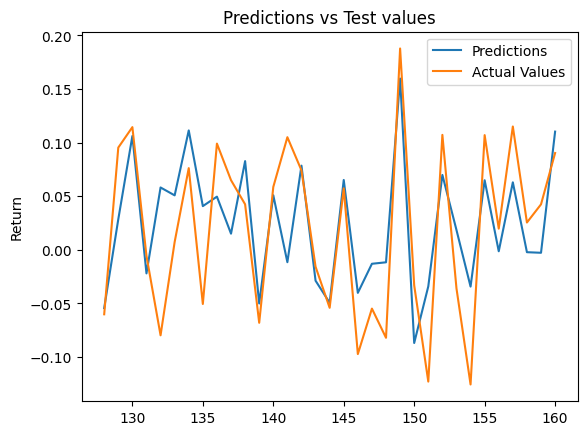

In [454]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
pd.DataFrame({'Predictions': preds, 'Actual Values': y_test}
             ).plot(kind='line', legend=True)
plt.title('Predictions vs Test values')
plt.ylabel('Return')
plt.show()

In [455]:
cv_score_r2.mean() # -> mean r^2

0.14212465645675648

In [456]:
np.abs(cv_score_mse.mean()) # -> mean mse

0.004993961724991973

In [457]:
r2_score(y_test, preds) # remove later

0.5339816357867795

#### Find top 25 features

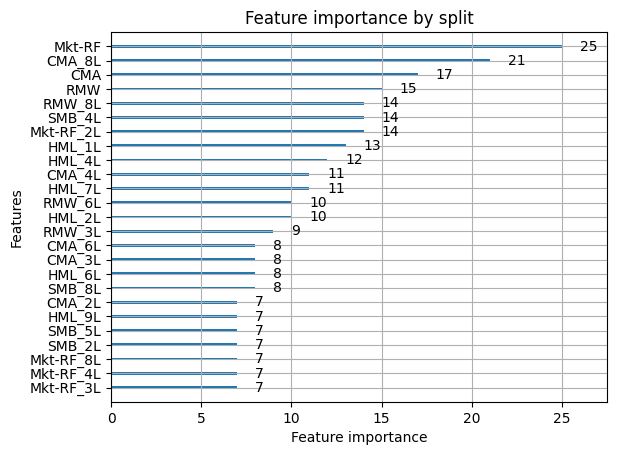

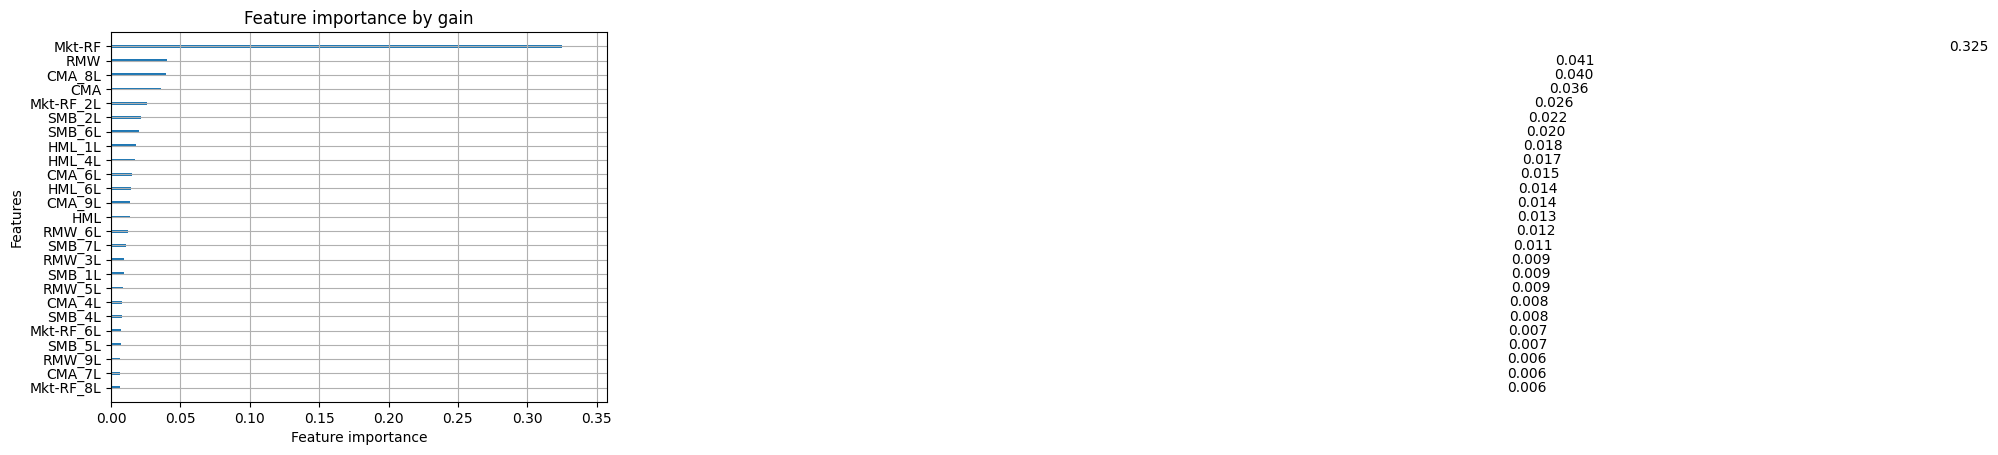

In [458]:
# fig = plt.plot(figsize=(15, 20))

top25 = 25

plot_importance(
    model_gbm,
    importance_type='split',
    max_num_features=min(top25, len(X.columns)),
    title="Feature importance by split",
)

plot_importance(
    model_gbm,
    importance_type='gain',
    max_num_features=min(top25, len(X.columns)),
    title="Feature importance by gain",
)

plt.show()

In [459]:
top15features_indexes = model_gbm.feature_importances_.argsort()[-15:]
top15features_stable = list(pd.Series(selected_features)[
                            top15features_indexes].values)

In [460]:
top15features_stable

['SMB_7L',
 'RMW_6L',
 'HML',
 'CMA_9L',
 'HML_6L',
 'CMA_6L',
 'HML_4L',
 'HML_1L',
 'SMB_6L',
 'SMB_2L',
 'Mkt-RF_2L',
 'CMA',
 'CMA_8L',
 'RMW',
 'Mkt-RF']

#### Compare to Lasso Regression

Обучать Lasso regression я буду на тех же фичах, что отобрал бустинг.

In [461]:
from time import time
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# .loc[:, top15features_stable]

t0 = time()
lasso_cv = LassoCV(max_iter=1000, cv=5).fit(
    X_train, y_train)
print(f"Lasso fit done in {(time() - t0):.3f}s")

y_pred_lasso = lasso_cv.predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso r^2 on test data : {r2_score_lasso:.3f}")

Lasso fit done in 0.056s
Lasso r^2 on test data : 0.660


In [462]:
sfm = SelectFromModel(lasso_cv, prefit=True)
X_train_selected = sfm.transform(X_train.values)
X_test_selected = sfm.transform(X_test.values)

In [463]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_selected, y_train)
y_pred_rf = model.predict(X_test_selected)
r2_score_rf = r2_score(y_test, y_pred_lasso)
print(f"Random forest r^2 on test data : {r2_score_rf:.3f}")

Random forest r^2 on test data : 0.660


Lasso $R^2$ > boosting $R^2$

In [464]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, Y)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

In [465]:
from sklearn.linear_model import ARDRegression

t0 = time()
ard = ARDRegression().fit(X_train_selected, y_train)
print(f"ARD fit done in {(time() - t0):.3f}s")

y_pred_ard = ard.predict(X_test_selected)
r2_score_ard = r2_score(y_test, y_pred_ard)
print(f"ARD r^2 on test data : {r2_score_ard:.3f}")

ARD fit done in 0.003s
ARD r^2 on test data : 0.742


$\Rightarrow$ best score!

In [526]:
'''
Create as model
'''


def objective_ardregr(trial):
    params = {
        'n_features_to_select': trial.suggest_int('n_features_to_select', 1, 30),
        'step': trial.suggest_int('step', 1, 10),
    }

    regr = RFEARDRegression(**params)
    regr.fit(X_train, y_train)
    preds = regr.predict(X_test)
    return r2_score(y_test, preds)


class RFEARDRegression:
    def __init__(self, n_features_to_select=5, step=1):
        self.n_features_to_select = n_features_to_select
        self.step = step
        self.estimator = SVR(kernel="linear")
        self.selector = RFE(
            self.estimator, n_features_to_select=self.n_features_to_select, step=self.step)
        self.ard = ARDRegression()

    def fit(self, X_train, y_train):
        X_train_selected = self.selector.fit_transform(X_train, y_train)
        self.ard.fit(X_train_selected, y_train)

    def predict(self, X_test):
        X_selected = self.selector.transform(X_test)
        return self.ard.predict(X_selected)

#### Compare to 5-factor Fama-French model

In [467]:
'''
Fama-French 5-Factor Model

Factors loaded from: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html#Research
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import getFamaFrenchFactors as gff


class FamaFrench5Factor:
    def __init__(self, _df) -> None:
        self.factor_names = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
        self.factors = pd.DataFrame(gff.famaFrench5Factor(frequency='m'))
        self.factors = self.factors.rename(columns={'date_ff_factors': 'Date'})
        self.df = _df

    def fit(self, _ticker, show_info=False):
        data = self._concat_stock_with_factors(_ticker)
        Y = data[_ticker] - data['RF']  # substract the risk free rate
        X = data[self.factor_names]

        # build model
        self.model = sm.OLS(Y, sm.tools.add_constant(X))
        result = self.model.fit()

        if show_info:
            print(result.summary())
            avr = self.factors.drop('Date', axis=1).apply(np.mean)
            Int, Mkt, SMB, HML, RMW, CMA = result.params
            exp_returns = Mkt*avr['Mkt-RF'] + SMB*avr['SMB'] + \
                HML*avr['HML'] + RMW*avr['RMW'] + CMA*avr['CMA']
            e_rets = exp_returns - data['RF'].mean()
            print(f'The expected monthly return for {_ticker} is:', e_rets)
            print(f'The expected anual return for {_ticker} is:', ((
                1 + e_rets) ** 12) - 1)

        return result

    def predict(self, X) -> np.array:
        # Ensure X has the same columns as the factors used in the model
        if not set(X.columns).issubset(set(self.factors.columns)):
            raise ValueError(
                "Input DataFrame must contain the same columns as the factors used in the model.")

        # Add a constant term to the input DataFrame
        X = sm.tools.add_constant(X)

        # Use the fitted model to predict the returns
        predictions = self.model.predict(X)

        return predictions

    def _concat_stock_with_factors(self, _ticker):
        mon = pd.DataFrame(self.df[_ticker]).resample('ME').last()
        mon_rets = mon.pct_change().dropna()
        data = pd.merge(mon_rets, self.factors, on='Date', how='left')
        data = data.set_index('Date')
        data = data.dropna()
        return data

    def get_params(self):
        return self.model.fit().params

    def factors_plot(self, _ticker) -> None:
        data = self._concat_stock_with_factors(_ticker)

        # Plot Fama-French factors
        plt.figure(figsize=(20, 10))
        fig3, axs = plt.subplots(1, 5)
        axs[0].plot(data['Mkt-RF'].rolling(3).mean(), linewidth=2.5)
        axs[0].plot(data[_ticker])
        axs[0].set_title('Stock compared to market returns')
        axs[1].plot(data['SMB'].rolling(3).mean(), linewidth=2.5)
        axs[1].plot(data[_ticker])
        axs[1].set_title('Stock compared to small company returns')
        axs[2].plot(data['HML'].rolling(3).mean(), linewidth=2.5)
        axs[2].plot(data[_ticker])
        axs[2].set_title('Stock compared to value stocks index')
        axs[3].plot(data['RMW'].rolling(3).mean(), linewidth=2.5)
        axs[3].plot(data[_ticker])
        axs[3].set_title('Stock compared to return on equity')
        axs[4].plot(data['CMA'].rolling(3).mean(), linewidth=2.5)
        axs[4].plot(data[_ticker])
        axs[4].set_title('Stock compared to investments')
        fig3.suptitle('Factors plot', fontsize=18)

        # Calculate correlations
        cor = data.corr()

        # Use.iloc[] to access values by their integer location
        print(f'{_ticker} correlation with market index:',
              cor['Mkt-RF'].iloc[0])
        print(f'{_ticker} correlation with small-company portfolio index:',
              cor['SMB'].iloc[0])
        print(f'{_ticker} correlation with value stocks index:',
              cor['HML'].iloc[0])
        print(f'{_ticker} correlation with return on equity index:',
              cor['RMW'].iloc[0])
        print(f'{_ticker} correlation with investments:',
              cor['HML'].iloc[0])

In [468]:
ff5_model = FamaFrench5Factor(df)
ff5_model.fit(tickers[0], True)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     28.88
Date:                Tue, 14 May 2024   Prob (F-statistic):           6.06e-21
Time:                        03:19:32   Log-Likelihood:                 245.29
No. Observations:                 170   AIC:                            -478.6
Df Residuals:                     164   BIC:                            -459.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0069      0.005      1.461      0.1

$R^2$ = 0.2194460492122819 (on cross-validation, boosting)

$R^2$ = 0.468 (for 5-factor Fama-French)

### Исследуем feature importance на случайной подвыборке из акций

In [511]:
def get_XY(ticker):
	mon = pd.DataFrame(df[ticker]).resample('ME').last()
	mon_rets = mon.pct_change().dropna()
	factors = ff5.rename(columns={'date_ff_factors': 'Date'})
	factors_0 = pd.merge(mon_rets, factors, on='Date', how='left')
	factors_0 = factors_0.dropna()
	Y = (factors_0[ticker] - factors_0['RF'])
	X = factors_0.drop(
							columns=['RF', ticker]).set_index('Date')
	return train_test_split(
            X, Y, test_size=0.2, shuffle=False)

In [512]:
N_stocks = 25
random_tickers = np.random.choice(df.columns, size=N_stocks)

In [ ]:
scores_dict = {}
top_features_dict = {}


for ticker in random_tickers:
	mon = pd.DataFrame(df[ticker]).resample('ME').last()
	mon_rets = mon.pct_change().dropna()
	factors = ff5.rename(columns={'date_ff_factors': 'Date'})
	factors_0 = pd.merge(mon_rets, factors, on='Date', how='left')
	factors_0 = factors_0.dropna()
	Y = (factors_0[ticker] - factors_0['RF'])
	X = factors_0.drop(
						columns=['RF', ticker]).set_index('Date')
	X_train, X_test, y_train, y_test = train_test_split(
						X, Y, test_size=0.2, shuffle=False)
	study = optuna.create_study(direction='maximize')
	study.optimize(objective, n_trials=200)
	best_params = study.best_params
	model_gbm = LGBMRegressor(**best_params)
	model_gbm.fit(X=X_train.loc[:, selected_features], y=y_train)
	preds = model_gbm.predict(X_test.loc[:, selected_features])

	cv_score_r2 = cross_val_score(
		model_gbm, X.loc[:, selected_features], Y, cv=5, scoring='r2')
	cv_score_mse = cross_val_score(
			model_gbm, X.loc[:, selected_features], Y, cv=5, scoring='neg_mean_squared_error')
	scores_dict[ticker] = [cv_score_r2.mean(), np.abs(cv_score_mse.mean())]

	top15features_indexes = model_gbm.feature_importances_.argsort()[-15:]
	top15features_stable = list(pd.Series(selected_features)[top15features_indexes].values)
	top_features_dict[ticker] = top15features_stable
	

#### Using 5-factor Fama-French

In [500]:
scores_dict_fama_french = {}
ff5_model = FamaFrench5Factor(df)

for ticker in random_tickers:
  scores_dict_fama_french[ticker] = ff5_model.fit(ticker).rsquared

#### Using RFEARDRegression

In [527]:
scores_dict_rfeard_regression = {}

for ticker in random_tickers:
  mon = pd.DataFrame(df[ticker]).resample('ME').last()
  mon_rets = mon.pct_change().dropna()
  factors = ff5.rename(columns={'date_ff_factors': 'Date'})
  factors_0 = pd.merge(mon_rets, factors, on='Date', how='left')
  factors_0 = factors_0.dropna()
  Y = (factors_0[ticker] - factors_0['RF'])
  X = factors_0.drop(
            columns=['RF', ticker]).set_index('Date')
  X_train, X_test, y_train, y_test = train_test_split(
            X, Y, test_size=0.2, shuffle=False)
  
  study = optuna.create_study(direction='maximize')
  study.optimize(objective_ardregr, n_trials=100)
  rfeard_regression = RFEARDRegression(**study.best_params)
  rfeard_regression.fit(X_train, y_train)
  y_preds = rfeard_regression.predict(X_test)
  scores_dict_rfeard_regression[ticker] = r2_score(y_test, y_preds)

[I 2024-05-15 19:21:04,469] A new study created in memory with name: no-name-b22006fb-b36a-4979-a7ca-8772bea3aaff


[I 2024-05-15 19:21:04,545] Trial 0 finished with value: -0.5530124531562932 and parameters: {'n_features_to_select': 30, 'step': 6}. Best is trial 0 with value: -0.5530124531562932.
[I 2024-05-15 19:21:04,566] Trial 1 finished with value: -0.5662342854573432 and parameters: {'n_features_to_select': 26, 'step': 7}. Best is trial 0 with value: -0.5530124531562932.
[I 2024-05-15 19:21:04,574] Trial 2 finished with value: -0.5092039501770751 and parameters: {'n_features_to_select': 14, 'step': 6}. Best is trial 2 with value: -0.5092039501770751.
[I 2024-05-15 19:21:04,595] Trial 3 finished with value: -0.5162816378028043 and parameters: {'n_features_to_select': 22, 'step': 1}. Best is trial 2 with value: -0.5092039501770751.
[I 2024-05-15 19:21:04,605] Trial 4 finished with value: -0.5541863371346307 and parameters: {'n_features_to_select': 28, 'step': 5}. Best is trial 2 with value: -0.5092039501770751.
[I 2024-05-15 19:21:04,612] Trial 5 finished with value: -0.2914346923184983 and para

Using Lasso

In [509]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

scores_dict_lasso = {}

# .loc[:, top15features_stable]
for ticker in random_tickers:
    mon = pd.DataFrame(df[ticker]).resample('ME').last()
    mon_rets = mon.pct_change().dropna()
    factors = ff5.rename(columns={'date_ff_factors': 'Date'})
    factors_0 = pd.merge(mon_rets, factors, on='Date', how='left')
    factors_0 = factors_0.dropna()
    Y = (factors_0[ticker] - factors_0['RF'])
    X = factors_0.drop(
                columns=['RF', ticker]).set_index('Date')
    X_train, X_test, y_train, y_test = train_test_split(
                X, Y, test_size=0.2, shuffle=False)
    
    # lasso
    lasso_cv = LassoCV(max_iter=10000, cv=5).fit(
        X_train, y_train)
    y_pred_lasso = lasso_cv.predict(X_test)
    scores_dict_lasso[ticker] = r2_score(y_test, y_pred_lasso)

In [529]:
import plotly.graph_objects as go

# Массивы данных
x1 = np.linspace(0, N_stocks, N_stocks)
y1 = [x[0] for x in scores_dict.values()]
x2 = np.linspace(0, N_stocks, N_stocks)
y2 = list(scores_dict_fama_french.values())
x3 = np.linspace(0, N_stocks, N_stocks)
y3 = list(scores_dict_rfeard_regression.values())
x4 = np.linspace(0, N_stocks, N_stocks)
y4 = list(scores_dict_lasso.values())
labels = list(scores_dict_fama_french.keys())

# Создание объектов линий
line1 = go.Scatter(x=x1, y=y1, mode='lines+markers', name='Boosting')
line2 = go.Scatter(x=x2, y=y2, mode='lines+markers', name='Fama-French')
line3 = go.Scatter(x=x3, y=y3, mode='lines+markers', name='ARD Regression')
line4 = go.Scatter(x=x4, y=y4, mode='lines+markers', name='Lasso')

# Создание объекта трассировки с подписями
trace = go.Scatter(x=(x1 + x2 + x3 + x4) // 4, y=y1 + y2 + y3 + y4, text=labels,
                   mode='text', textposition='top center', showlegend=False)

# Создание фигуры и добавление трассировок
fig = go.Figure(data=[line1, line2, line3, line4, trace])

# Настройка отображения графика
fig.update_layout(title='Models scores',
                  yaxis_title='r2_score',
                  legend_title='Model')

# Отображение графика
fig.show()

In [ ]:
from collections import defaultdict

d = defaultdict(int)

